<h1 style="color:darkgreen; text-align:center; text-decoration: underline;">AIDI1005 - AI for Decision Making</h1>

####  Loading the Dataset
--------
We start by loading the dataset (reduced_imdb_movie_reviews.csv) containing movie reviews and their corresponding sentiment labels using pandas. We display the first few rows of the dataset to understand its structure.

In [1]:
import pandas as pd

# Load the dataset
file_path = r'C:\AIDI\Semester 1\Assignments\AI for Decision Making\Project 3\IMDB_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,review,sentiment
0,I thought this was a wonderful way to spend ti...,positive
1,"Probably my all-time favorite movie, a story o...",positive
2,I sure would like to see a resurrection of a u...,positive
3,"This show was an amazing, fresh & innovative i...",negative
4,Encouraged by the positive comments about this...,negative


In [2]:
# Check the distribution of sentiments
sentiment_counts = data['sentiment'].value_counts()
sentiment_counts


sentiment
positive    12500
negative    12500
Name: count, dtype: int64

In [3]:
# Ensure there are at least 3000 positive and negative reviews
positive_reviews = data[data['sentiment'] == 'positive'].sample(n=4000, random_state=42)
negative_reviews = data[data['sentiment'] == 'negative'].sample(n=4000, random_state=42)

# Combine the reduced datasets
reduced_data = pd.concat([positive_reviews, negative_reviews])

# Shuffle the dataset to mix positive and negative reviews
reduced_data = reduced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the reduced dataset
reduced_data.to_csv(r'C:\AIDI\Semester 1\Assignments\AI for Decision Making\Project 3\reduced_imdb_movie_reviews.csv', index=False)

# Display the shape of the reduced dataset
reduced_data.shape

(8000, 2)

This reduces the dataset to a manageable size, and saves it for further analysis or modeling.

------------

In [4]:
# Check the distribution of sentiments in the reduced dataset
reduced_sentiment_counts = reduced_data['sentiment'].value_counts()
reduced_sentiment_counts

sentiment
positive    4000
negative    4000
Name: count, dtype: int64

This confirms that the dataset is balanced and contains an equal number of positive and negative reviews.

-------

In [5]:
# Load the reduced dataset
file_path = r'C:\AIDI\Semester 1\Assignments\AI for Decision Making\Project 3\reduced_imdb_movie_reviews.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,review,sentiment
0,Filmed by MGM on the same sets as the English ...,positive
1,From what I've read a lot of people were disap...,positive
2,In following the lines of the classic formula ...,positive
3,"The first ""side-story"" in the universal centur...",positive
4,Please make me forget. Please. Please. This is...,negative


####  Text Preprocessing
----------------
The text preprocessing performed on the dataset serves the following purposes:

1. **Remove Noise**: Punctuation, stopwords (e.g., "the," "is"), and irrelevant words are removed to ensure the text focuses on important content.
2. **Text Normalization**: Converting all words to lowercase and applying lemmatization (reducing words to their base forms) helps standardize the text, making it consistent for analysis.

In [8]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the text data
data['processed_reviews'] = data['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nmlto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nmlto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nmlto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# Display the first few rows after preprocessing
data[['review', 'processed_reviews']].head()

,review,processed_reviews
0,Filmed by MGM on the same sets as the English ...,filmed mgm set english version german garbo se...
1,From what I've read a lot of people were disap...,ive read lot people disappointed film compared...
2,In following the lines of the classic formula ...,following line classic formula point taking an...
3,"The first ""side-story"" in the universal centur...",first sidestory universal century gundam unive...
4,Please make me forget. Please. Please. This is...,please make forget please please worst film ev...


The cleaned text is now in a form suitable for machine learning models by improving the quality and relevance of the features.

#### TF-IDF Vectorization
-------------
We apply TF-IDF to transform text into numerical data, prioritizing words based on how frequently they appear and how rare they are. Restricting the features to the top 3000 reduces data complexity, prevents overfitting, and enhances model performance.

In [ ]:
pip install xgboost

In [39]:
# Initialize the TF-IDF Vectorizer with a specific number of features (3000 in this case)
tfidf_vect = TfidfVectorizer(max_features=4000)
X_tfidf = tfidf_vect.fit_transform(data['processed_reviews'])

# Get the feature names (words) corresponding to the top features
feature_names = tfidf_vect.get_feature_names_out()

# Display the array of words
print("Array of words (features):")
print(feature_names)

Array of words (features):
['10' '100' '1010' ... 'zero' 'zombie' 'zone']


#### Encoding Sentiment Labels
---------------
The sentiment labels (positive/negative) are categorical. We use LabelEncoder to convert these labels into integers (0 for negative, 1 for positive) so that they can be processed by machine learning algorithms.

In [40]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])  

#### Train-Test Split 
--------------
To evaluate the model, we split the dataset into two parts:

Training data (80%): Used to train the model and Test data (20%): Used to evaluate model performance.
This ensures that the model is trained on one subset of data and evaluated on a separate subset, giving a more accurate estimate of performance.

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

#### Model Training with GridSearchCV
------------------
We use two machine learning models, Random Forest and Gradient Boosting, and tune their hyperparameters using GridSearchCV. This method finds the best combination of hyperparameters by testing various options and using cross-validation.

In [42]:
# Define parameter grids for both Random Forest and Gradient Boosting
rf_params = {'n_estimators': [50, 100], 'max_depth': [10, 20, None]}
gb_params = {'n_estimators': [50, 100], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.05]}

# Initialize Random Forest and Gradient Boosting models
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()

# Initialize GridSearchCV for both models
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, n_jobs=-1, verbose=1)
gb_grid = GridSearchCV(gb_model, gb_params, cv=3, n_jobs=-1, verbose=1)

# Fit both models using GridSearchCV
rf_grid.fit(X_train, y_train)
gb_grid.fit(X_train, y_train)

# Display best parameters for both models
print("Random Forest Best Params:", rf_grid.best_params_)
print("Gradient Boosting Best Params:", gb_grid.best_params_)

# Evaluate the best models on the test set
rf_best_model = rf_grid.best_estimator_
gb_best_model = gb_grid.best_estimator_

# Make predictions on the test set
rf_predictions = rf_best_model.predict(X_test)
gb_predictions = gb_best_model.predict(X_test)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Random Forest Best Params: {'max_depth': 20, 'n_estimators': 100}
Gradient Boosting Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


For Random Forest, the best parameters found are max_depth=20 and n_estimators=100, meaning it uses 20 tree depth and 100 trees. For Gradient Boosting, the best parameters are learning_rate=0.1, max_depth=7, and n_estimators=100, which control the model's learning rate, tree depth, and the number of trees, respectively.

#### Evaluation of the Best Model
--------------------
After training, we evaluate the models using the following metrics:

- **Confusion Matrix**:  
  A matrix that shows how well the model predicts positive and negative sentiments. It helps to understand the number of true positives, false positives, true negatives, and false negatives.

In [43]:
# Evaluate Random Forest
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)

# Evaluate Gradient Boosting
gb_best = gb_grid.best_estimator_
y_pred_gb = gb_best.predict(X_test)

# Calculate and display evaluation metrics
print("Random Forest Confusion Matrix: \n\n",confusion_matrix(y_test, y_pred_rf))
print("Gradient Boosting Confusion Matrix: \n\n",confusion_matrix(y_test, y_pred_gb))

Random Forest Confusion Matrix: 

 [[654 146]
 [111 689]]
Gradient Boosting Confusion Matrix: 

 [[640 160]
 [113 687]]


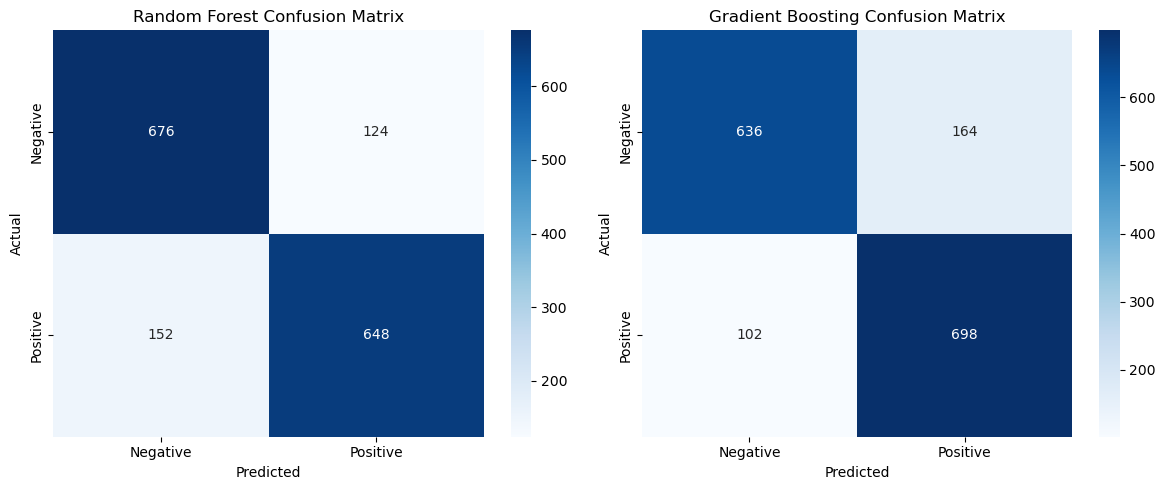

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test, y_pred_rf)

# Confusion Matrix for Gradient Boosting
gb_cm = confusion_matrix(y_test, y_pred_gb)

# Plotting Random Forest and Gradient Boosting Confusion Matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

# Random Forest Confusion Matrix
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Gradient Boosting Confusion Matrix
sns.heatmap(gb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1])
axes[1].set_title('Gradient Boosting Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Show the plot
plt.tight_layout()  
plt.show()

- **Classification Report**:  
  This includes several important metrics:
  - **Precision**: The proportion of true positive predictions out of all positive predictions made by the model.
  - **Recall**: The proportion of true positive predictions out of all actual positive instances in the dataset.
  - **F1-score**: The harmonic mean of precision and recall, offering a balanced measure of the model's performance.
  ------------

In [44]:
print("\nRandom Forest Classification Report: \n\n",classification_report(y_test, y_pred_rf))
print("\nGradient Boosting Classification Report: \n\n",classification_report(y_test, y_pred_gb))


Random Forest Classification Report: 

               precision    recall  f1-score   support

           0       0.85      0.82      0.84       800
           1       0.83      0.86      0.84       800

    accuracy                           0.84      1600
   macro avg       0.84      0.84      0.84      1600
weighted avg       0.84      0.84      0.84      1600


Gradient Boosting Classification Report: 

               precision    recall  f1-score   support

           0       0.85      0.80      0.82       800
           1       0.81      0.86      0.83       800

    accuracy                           0.83      1600
   macro avg       0.83      0.83      0.83      1600
weighted avg       0.83      0.83      0.83      1600



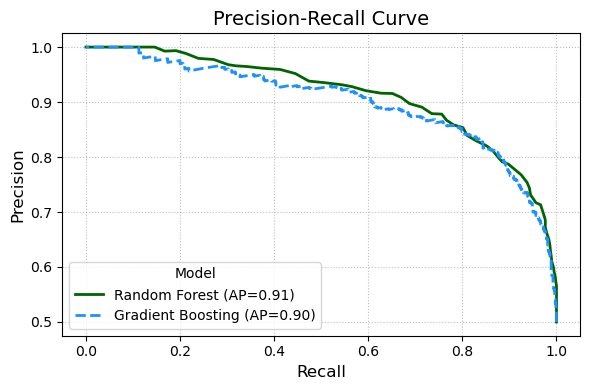

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_best.predict_proba(X_test)[:, 1])
avg_precision_rf = average_precision_score(y_test, rf_best.predict_proba(X_test)[:, 1])

# Precision-Recall Curve for Gradient Boosting
precision_gb, recall_gb, _ = precision_recall_curve(y_test, gb_best.predict_proba(X_test)[:, 1])
avg_precision_gb = average_precision_score(y_test, gb_best.predict_proba(X_test)[:, 1])

# Plotting Precision-Recall curve for both models with smaller figure and added features
plt.figure(figsize=(6, 4))  # Smaller figure size
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP={avg_precision_rf:.2f})', color='darkgreen', linestyle='-', linewidth=2)
plt.plot(recall_gb, precision_gb, label=f'Gradient Boosting (AP={avg_precision_gb:.2f})', color='dodgerblue', linestyle='--', linewidth=2)

# Adding gridlines
plt.grid(True, linestyle=':', color='gray', alpha=0.5)

# Adding titles and labels
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)

# Displaying the legend with a title and custom position
plt.legend(loc='lower left', title='Model', fontsize=10)

# Display the plot
plt.tight_layout()  
plt.show()

### Conclusion and Model Performance Comparison

#### **Confusion Matrix Insights:**
- **Random Forest:**
  - **True Negatives (TN):** 654, **False Positives (FP):** 146
  - **False Negatives (FN):** 111, **True Positives (TP):** 689
- **Gradient Boosting:**
  - **True Negatives (TN):** 640, **False Positives (FP):** 160
  - **False Negatives (FN):** 113, **True Positives (TP):** 687

Both models show similar performance, with Random Forest having a slight edge in true negatives.

#### **Classification Report:**
- **Precision:**
  - Random Forest: 0.85 (class 0), 0.83 (class 1)
  - Gradient Boosting: 0.85 (class 0), 0.81 (class 1)
  - **Random Forest** outperforms for class 1.

- **Recall:**
  - Random Forest: 0.82 (class 0), 0.86 (class 1)
  - Gradient Boosting: 0.80 (class 0), 0.86 (class 1)
  - Both models are similar for class 1, but **Random Forest** performs better for class 0.

- **F1-Score:**
  - Random Forest: 0.84 (both classes)
  - Gradient Boosting: 0.82 (class 0), 0.83 (class 1)
  - **Random Forest** has a higher overall F1-score.

- **Accuracy:**
  - Random Forest: 84%
  - Gradient Boosting: 83%
  - **Random Forest** is slightly more accurate.

#### **Key Insights:**
- **Random Forest** outperforms **Gradient Boosting** in accuracy, F1-score, and class 1 precision.
- Both models handle false positives and negatives well, but **Random Forest** is better at predicting class 1.

#### **Conclusion:**
While both models perform well, **Random Forest** shows a slight advantage in terms of accuracy, precision, and F1-score. The differences are likely due to Random Forest's ensemble method, which tends to generalize better, compared to Gradient Boosting’s sensitivity to overfitting.
